In [56]:
from scipy import stats
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
%matplotlib inline
# sns.set_style("whitegrid", {"grid.color": "1", "grid.linestyle": ""})
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# plt.style.use('seaborn-whitegrid')

In [21]:
def read_each_csv(filename="curve.csv"):

    df = pd.read_csv(filename,encoding= 'unicode_escape' )
    # add a column to calculate y data


    return df

df= read_each_csv("avif_25.csv")
df

,name,height,width,file_size(kb),method,compression_level
0,artificial,853,1280,24,avif,25
1,big_building,960,1280,40,avif,25
2,big_tree,957,1280,52,avif,25
3,bridge,1885,1280,60,avif,25
4,cathedral,1925,1280,36,avif,25
5,deer,836,1280,12,avif,25
6,fireworks,960,1280,20,avif,25
7,flower_foveon,853,1280,12,avif,25
8,hdr,853,1280,12,avif,25
9,leaves_iso_200,851,1280,80,avif,25


In [22]:
import glob
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
all_csv = []
# loop over the list of csv files
for f in csv_files:
    print(f)
    all_csv.append(read_each_csv(f))

c:\Users\Gan Qi Wen\birdfy\experiment\avif_25.csv
c:\Users\Gan Qi Wen\birdfy\experiment\avif_60.csv
c:\Users\Gan Qi Wen\birdfy\experiment\avif_90.csv
c:\Users\Gan Qi Wen\birdfy\experiment\jpeg6b_25.csv
c:\Users\Gan Qi Wen\birdfy\experiment\jpeg6b_60.csv
c:\Users\Gan Qi Wen\birdfy\experiment\jpeg6b_90.csv
c:\Users\Gan Qi Wen\birdfy\experiment\jpegxl_25.csv
c:\Users\Gan Qi Wen\birdfy\experiment\jpegxl_60.csv
c:\Users\Gan Qi Wen\birdfy\experiment\jpegxl_90.csv


In [23]:
df = pd.concat(all_csv)
print(df)

                 name  height  width  file_size(kb)  method  compression_level
0          artificial     853   1280             24    avif                 25
1        big_building     960   1280             40    avif                 25
2            big_tree     957   1280             52    avif                 25
3              bridge    1885   1280             60    avif                 25
4           cathedral    1925   1280             36    avif                 25
..                ...     ...    ...            ...     ...                ...
7       flower_foveon     853   1280             72  jpegxl                 90
8                 hdr     853   1280            120  jpegxl                 90
9      leaves_iso_200     851   1280            368  jpegxl                 90
10  nightshot_iso_100     960   1280            140  jpegxl                 90
11         spider_web     857   1280             88  jpegxl                 90

[108 rows x 6 columns]


## Calculate mean bpp categorized by level of storage requirement

In [24]:
df["bpp"]=df["file_size(kb)"]* 1024 * 8 / (df["width"] * df["height"])

# df.iloc[0]
df.iloc[30]


name                 fireworks
height                     960
width                     1280
file_size(kb)              168
method                    avif
compression_level           90
bpp                       1.12
Name: 6, dtype: object

In [25]:
# query by compression level
# df1=df.loc[(df['compression_level'] == 25)]


mean_bpp = df.groupby(['method','compression_level'])['bpp'].mean().reset_index()
mean_bpp

,method,compression_level,bpp
0,avif,25,0.190935
1,avif,60,0.811048
2,avif,90,2.938428
3,jpeg6b,25,0.466499
4,jpeg6b,60,0.793211
5,jpeg6b,90,1.810387
6,jpegxl,25,0.301289
7,jpegxl,60,0.504124
8,jpegxl,90,1.334531


In [26]:
# import all the metrics
import torch
from kornia.losses import ssim_loss as dssim
import lpips 
from flip_loss import LDRFLIPLoss, HDRFLIPLoss



def mse(image_pred, image_gt, valid_mask=None, reduction='mean'):
    value = (image_pred-image_gt)**2
    if valid_mask is not None:
        value = value[valid_mask]
    if reduction == 'mean':
        return torch.mean(value)
    return value

def psnr(image_pred, image_gt, valid_mask=None, reduction='mean'):
    return -10*torch.log10(mse(image_pred, image_gt, valid_mask, reduction))

def ssim(image_pred, image_gt, reduction='mean'):
    """
    image_pred and image_gt: (1, 3, H, W)
    """
    dssim_ = dssim(image_pred, image_gt, 3, reduction=reduction) # dissimilarity in [0, 1]
    return 1-2*dssim_ # in [-1, 1]

def lpips_lib(image_pred, image_gt,loss_fn):
    return loss_fn.forward(image_pred, image_gt)

def flip_lib(image_pred, image_gt,loss_fn):
    return loss_fn.forward(image_pred, image_gt)

In [41]:
from torchvision import transforms
from PIL import Image
## Calculate qualitative result between GT and compressed images
img0 = torch.ones(1,3,64,64) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = torch.rand(1,3,64,64)
convert_tensor = transforms.ToTensor()

def calculate_qualitative(img0,img1):
    # img0.to("cuda")
    # img1.to("cuda")
    psnr_result= psnr(img0,img1)
    ssim_result= ssim(img0,img1)
    flip_loss_fn = LDRFLIPLoss()
    flip_result= flip_lib(img0,img1,flip_loss_fn).squeeze()

    # print(psnr_result)
    # print(flip_result)
    # print(lpips_result)

    return psnr_result.detach().cpu().float(),ssim_result.detach().numpy(),flip_result.detach().cpu().float()

# path = os.getcwd("")
def calculate_qualitative_wrapper(row):
    """take a input row from pd dataframe
    
    """
    methods=row["method"]
    compress_level=row["compression_level"]
    subject=row["name"]
    GT_files = os.path.join("low_res", "{}.png".format(subject))
    compress_files = os.path.join("{0}_{1}_output".format(methods,compress_level), "{}_dec.jpeg".format(subject))
    print(GT_files)
    print(compress_files)
    gt_img_ts = convert_tensor(Image.open(GT_files)).unsqueeze(dim=0)
    cf_img_ts = convert_tensor(Image.open(compress_files)).unsqueeze(dim=0)
    print(gt_img_ts.shape)
    print(cf_img_ts.shape)
    # read image into tensor format 1:3:W:H
    return calculate_qualitative(gt_img_ts,cf_img_ts)

calculate_qualitative_wrapper(df.iloc[0])


low_res\artificial.png
avif_25_output\artificial_dec.jpeg
torch.Size([1, 3, 853, 1280])
torch.Size([1, 3, 853, 1280])


(tensor(31.4080), array(0.8828531, dtype=float32), tensor(0.0636))

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

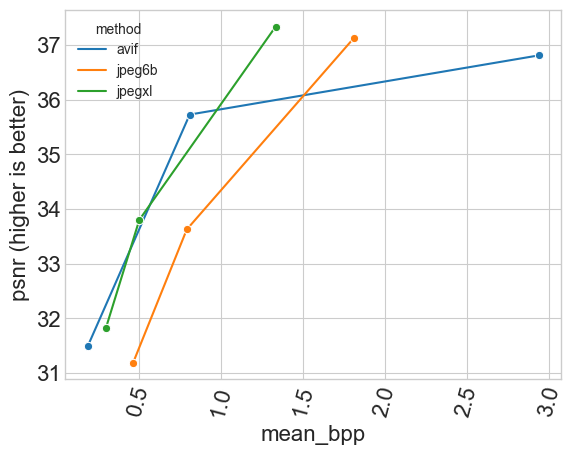

In [66]:
# df[['psnr',"ssim",'flip']] = df.apply(calculate_qualitative_wrapper, axis=1,result_type="expand")
# df.to_csv("final_result_with_metrics.csv")

data = read_each_csv("final_result_with_metrics.csv")
data
mean_psnr = df.groupby(['method','compression_level'])['psnr'].mean().reset_index()
mean_bpp = df.groupby(['method','compression_level'])['bpp'].mean().reset_index()

mean_psnr ["mean_bpp"] = mean_bpp["bpp"]
mean_psnr= mean_psnr.rename(columns={"psnr": "psnr (higher is better)"})
## plot graphs 
sns.lineplot(data=mean_psnr,x="mean_bpp", y="psnr (higher is better)",hue="method",marker='o',palette="tab10")
plt.xticks(rotation=75)

,method,compression_level,ssim (lower is better),mean_bpp
0,avif,25,0.839043,0.190935
1,avif,60,0.902192,0.811048
2,avif,90,0.917920,2.938428
3,jpeg6b,25,0.837582,0.466499
4,jpeg6b,60,0.879398,0.793211
5,jpeg6b,90,0.921258,1.810387
6,jpegxl,25,0.851392,0.301289
7,jpegxl,60,0.882574,0.504124
8,jpegxl,90,0.923943,1.334531


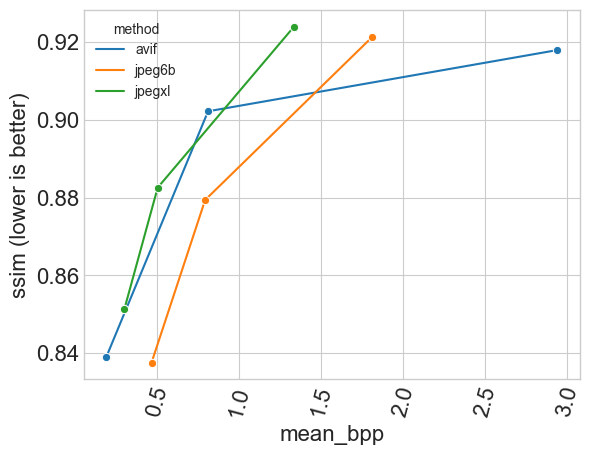

In [74]:
mean_ssim = df.groupby(['method','compression_level'])['ssim'].mean().reset_index()
mean_bpp = df.groupby(['method','compression_level'])['bpp'].mean().reset_index()

mean_ssim ["mean_bpp"] = mean_bpp["bpp"]
mean_ssim=mean_ssim.rename(columns={"ssim": "ssim (lower is better)"})
sns.lineplot(data=mean_ssim,x="mean_bpp", y="ssim (lower is better)",hue="method",marker='o',palette="tab10")
plt.xticks(rotation=75)
mean_ssim

,method,compression_level,flip (lower is better),mean_bpp
0,avif,25,0.080297,0.190935
1,avif,60,0.043781,0.811048
2,avif,90,0.032732,2.938428
3,jpeg6b,25,0.076150,0.466499
4,jpeg6b,60,0.050981,0.793211
5,jpeg6b,90,0.029841,1.810387
6,jpegxl,25,0.068075,0.301289
7,jpegxl,60,0.051064,0.504124
8,jpegxl,90,0.030805,1.334531


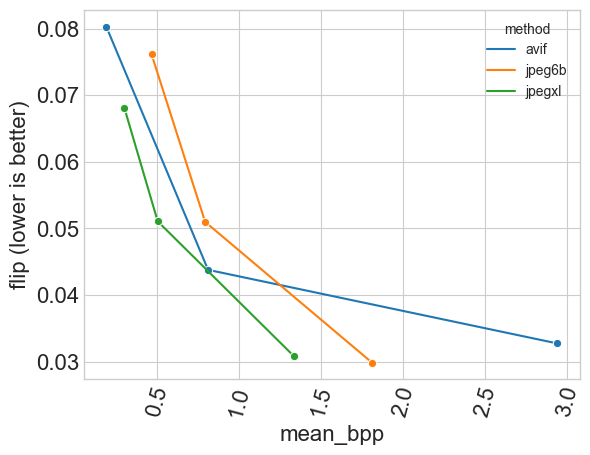

In [75]:
mean_flip = df.groupby(['method','compression_level'])['flip'].mean().reset_index()
mean_bpp = df.groupby(['method','compression_level'])['bpp'].mean().reset_index()

mean_flip ["mean_bpp"] = mean_bpp["bpp"]
mean_flip=mean_flip.rename(columns={"flip": "flip (lower is better)"})
sns.lineplot(data=mean_flip,x="mean_bpp", y="flip (lower is better)",hue="method",marker='o',palette="tab10")
plt.xticks(rotation=75)
mean_flip